In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K

/home/buikhoi/miniconda3/envs/ComputerVision/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/buikhoi/miniconda3/envs/ComputerVision/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/buikhoi/miniconda3/envs/ComputerVision/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [100]:
MEANS = (0.406, 0.456, 0.485)
STDS = (0.225, 0.224, 0.229)

In [4]:
class NumpyDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images_link, in_dim, out_dim, batch_size=32, shuffle=False):
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.batch_size = batch_size
        self.images_link = images_link
        self.shuffle = shuffle
        self.images = [images_link + f for f in os.listdir(images_link)]
        self.indexes = None
        self.on_epoch_end()
        print('Data generator on {} images'.format(len(self.images)))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.images)//self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        #print('Index: {}'.format(index))
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_images_temp = [self.images[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_images_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_images_temp):
        '''
        Generate data with the specified batch size
        '''
        # Initialization
        X = np.empty((self.batch_size, *self.in_dim, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.out_dim, 1), dtype=np.float32)

        for i, img in enumerate(list_images_temp):
            image = cv2.imread(img, cv2.IMREAD_UNCHANGED)
            anno = cv2.resize(image[:, :, -1]/255, (self.out_dim[1], self.out_dim[0]))
            
            X[i,] = image[:, :, :3]/255
            y[i,] = np.expand_dims(anno, -1)/255

        return X, y

In [5]:
train_gen = NumpyDataGenerator(
    './training_images/train/', 
    (288, 800), 
    (36, 100), 
    batch_size=32,
    shuffle=True
)

Data generator on 2837 images


In [6]:
train_gen.__len__()

88

In [7]:
X, y = train_gen.__getitem__(0)

In [8]:
X.shape

(32, 288, 800, 3)

In [9]:
y.shape

(32, 36, 100, 1)

In [10]:
from matplotlib import pyplot as plt

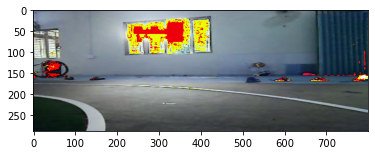

In [11]:
plt.imshow(X[1])

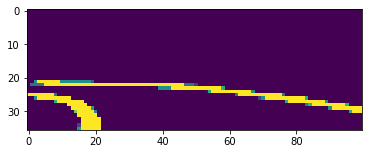

In [12]:
plt.imshow(y[1])

In [13]:
X[0]

array([[[0.6862745 , 0.5764706 , 0.6156863 ],
        [0.7921569 , 0.6901961 , 0.74509805],
        [0.78431374, 0.68235296, 0.72156864],
        ...,
        [0.15686275, 0.1764706 , 0.1764706 ],
        [0.19215687, 0.20784314, 0.21568628],
        [0.22352941, 0.23529412, 0.24313726]],

       [[0.7529412 , 0.67058825, 0.68235296],
        [0.74509805, 0.6627451 , 0.6666667 ],
        [0.7529412 , 0.6784314 , 0.6745098 ],
        ...,
        [0.14117648, 0.16470589, 0.15686275],
        [0.15294118, 0.16470589, 0.14901961],
        [0.16078432, 0.16862746, 0.14901961]],

       [[0.73333335, 0.6901961 , 0.6431373 ],
        [0.7411765 , 0.69803923, 0.64705884],
        [0.7529412 , 0.7019608 , 0.654902  ],
        ...,
        [0.16078432, 0.18039216, 0.16470589],
        [0.19215687, 0.2       , 0.1764706 ],
        [0.21176471, 0.21568628, 0.1882353 ]],

       ...,

       [[0.3254902 , 0.4       , 0.43137255],
        [0.33333334, 0.40784314, 0.4392157 ],
        [0.32941177, 0

In [67]:
plt.imshow(normed_image)

(array([[105.24052083],
        [106.9153559 ],
        [ 94.58540365]]),
 array([[53.16743262],
        [49.40509646],
        [46.17841774]]))

In [93]:
def normalize(image, means, stds):
    new_image = np.empty(image.shape, np.float32)
    for i in range(3):
        sub_image = image[:, :, i]
        sub_image = (sub_image - sub_image.mean()) / sub_image.std() * stds[i] + means[i]
        new_image[:, :, i] = sub_image
    return new_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


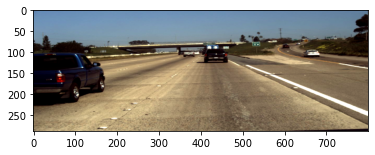

In [99]:
normed_img = normalize(X[2], )
plt.imshow(normed_img[:, :, (2, 1, 0)])

In [96]:
normed_img[:, :, 0].std()

0.225

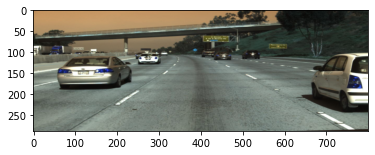

In [90]:
plt.imshow(X[0].astype('int'))

In [15]:
from classification_models.tfkeras import Classifiers

In [18]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
model = ResNet18((288, 800, 3), weights=None, include_top=False)

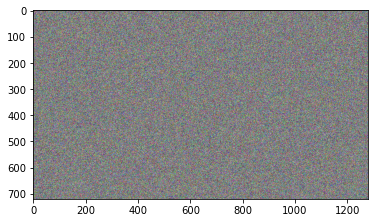

In [22]:
image = np.random.random((720, 1280, 3))
image = preprocess_input(image)
plt.imshow(image)

In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 288, 800, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 288, 800, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_36 (ZeroPadding2 (None, 294, 806, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 144, 400, 64) 9408        zero_padding2d_36[0][0]          
____________________________________________________________________________________________

In [27]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
def construct_model(IMG_HEIGHT, IMG_WIDTH):
    resnet = ResNet18((IMG_HEIGHT, IMG_WIDTH, 3), weights=None, include_top=False)

    output = resnet.layers[-1].output
    output = Flatten()(output)
    restnet = Model(inputs=resnet.input, outputs=output)

    for layer in restnet.layers:
        layer.trainable = False

    model = Sequential()
    model.add(resnet)

    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal'))

    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(3, 3, activation='relu', padding='same', kernel_initializer='he_normal'))

    return model

In [28]:
model = construct_model(288, 800)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 9, 25, 512)        11186889  
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 18, 50, 512)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 50, 256)       524544    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 50, 256)       590080    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 50, 256)       590080    
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 36, 100, 256)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 100, 128)     